In [15]:
import sys, os
sys.path.insert(0, os.path.abspath("../src"))

from model_eval import evaluate_model
from breed_and_battle import breed_and_battle
from resampling import (
    manual_upsampling, smote, adasyn, borderline_smote,
    smote_tomek, smote_enn, random_undersample, cluster_centroids
)

In [17]:
# 📦 Standard setup: load, split, and prep data
from preprocessing import load_and_prepare_data, split_and_scale, select_top_features

# 📂 Path to your dataset
data_path = "../data/synth_rare_event_data.csv"
target_col = "rare_event"

# 🧼 Load and prepare
X, y = load_and_prepare_data(data_path, target_col)
X_train_scaled, X_test_scaled, y_train, y_test = split_and_scale(X, y)
X_train, X_test, _ = select_top_features(X_train_scaled, y_train, X_test_scaled, return_features=True)

In [19]:
# 📊 Define resampling strategies
resamplers = {
    "Manual Upsampling": lambda: manual_upsampling(X_train, y_train, target_col),
    "SMOTE": lambda: smote(X_train, y_train),
    "ADASYN": lambda: adasyn(X_train, y_train),
    "Borderline SMOTE": lambda: borderline_smote(X_train, y_train),
    "SMOTETomek": lambda: smote_tomek(X_train, y_train),
    "SMOTEENN": lambda: smote_enn(X_train, y_train),
    "Random Undersample": lambda: random_undersample(X_train, y_train),
    "Cluster Centroids": lambda: cluster_centroids(X_train, y_train),
    "No Resampling": lambda: (X_train, y_train)
}

In [20]:
resampled_datasets = {
    name: fn() for name, fn in resamplers.items()
}

population = breed_and_battle(
    resampled_datasets=resampled_datasets,
    X_test=X_test,
    y_test=y_test,
    generations=200,
    top_k=3,
    debug=True  # Set to False to suppress commentary
)


🎬 Initial Fighters Enter the Arena!


/Users/sophiaboettcher/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



🎮 Generation 1 Begins!
-------------------------
🏆 Top Performers:
1. Cluster Centroids_G0: PR AUC = 0.043
2. Manual Upsampling_G0: PR AUC = 0.035
3. Random Undersample_G0: PR AUC = 0.032

💘 Cluster Centroids breeds 2 children

👊 Cluster Centroids_child_1_G1 is ready to make waves!
📍 Style: Cluster Centroids
🧬 Genome: C = 1.05, l1_ratio = 0.57
🔁 Generation: 1
🏆 Last Score: PR AUC = 0.040
🧬 Lineage: child of Cluster Centroids_G0

👊 Cluster Centroids_child_2_G1 is ready to make waves!
📍 Style: Cluster Centroids
🧬 Genome: C = 1.03, l1_ratio = 0.55
🔁 Generation: 1
🏆 Last Score: PR AUC = 0.040
🧬 Lineage: child of Cluster Centroids_G0

💘 Manual Upsampling breeds 2 children

👊 Manual Upsampling_child_1_G1 is ready to make waves!
📍 Style: Manual Upsampling
🧬 Genome: C = 0.92, l1_ratio = 0.59
🔁 Generation: 1
🏆 Last Score: PR AUC = 0.035
🧬 Lineage: child of Manual Upsampling_G0

👊 Manual Upsampling_child_2_G1 is ready to make waves!
📍 Style: Manual Upsampling
🧬 Genome: C = 1.05, l1_ratio = 0.50

In [23]:
# 🏁 Final Round Summary

# Sort population by PR AUC
final_results = sorted(population, key=lambda x: x["score"]["pr_auc"], reverse=True)

champion = final_results[0]

print("\n🏆 GRAND CHAMPION 🏆")
print(f"👑 Name: {champion['label']}")
print(f"🔁 Generation: {champion['generation']}")
print(f"🧬 Genome: C = {champion['params']['C']:.2f}, l1_ratio = {champion['params']['l1_ratio']:.2f}")
print(f"📈 PR AUC: {champion['score']['pr_auc']:.3f}")
print(f"🎖 ROC AUC: {champion['score']['roc_auc']:.3f}")
print(f"🧬 Lineage: {champion.get('lineage', 'Origin Unknown')}")


🏆 GRAND CHAMPION 🏆
👑 Name: Cluster Centroids
🔁 Generation: 28
🧬 Genome: C = 0.94, l1_ratio = 0.48
📈 PR AUC: 0.043
🎖 ROC AUC: 0.639
🧬 Lineage: child of Cluster Centroids_G12


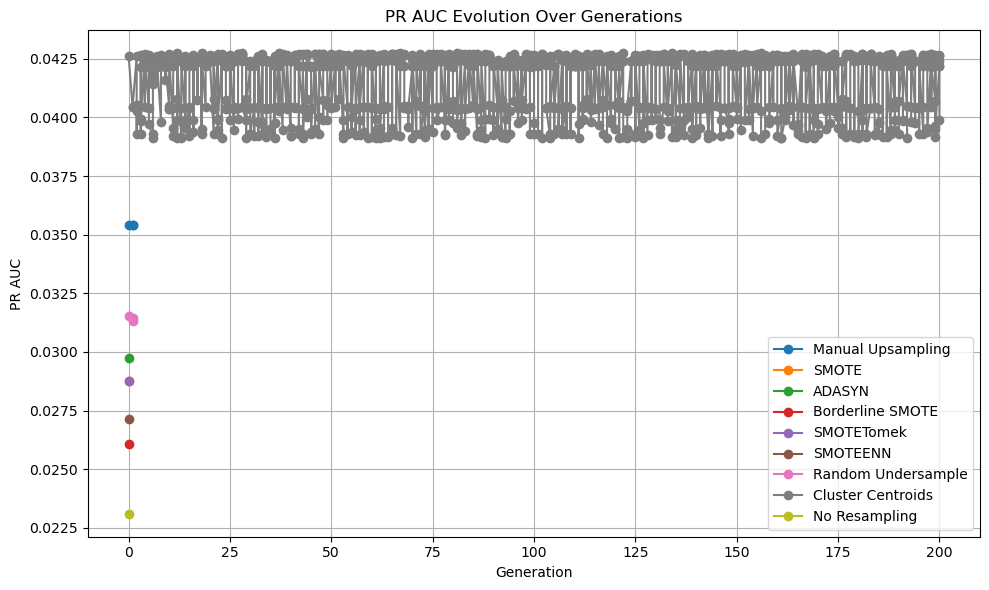

In [29]:
import pandas as pd
import matplotlib.pyplot as plt


tracking_df = pd.DataFrame([
    {
        "Generation": model["generation"],
        "Strategy": model["label"],
        "PR AUC": model["score"]["pr_auc"],
        "ROC AUC": model["score"]["roc_auc"]
    }
    for model in population
])

plt.figure(figsize=(10, 6))
for strat in tracking_df["Strategy"].unique():
    group = tracking_df[tracking_df["Strategy"] == strat]
    plt.plot(group["Generation"], group["PR AUC"], marker="o", label=strat)

plt.title("PR AUC Evolution Over Generations")
plt.xlabel("Generation")
plt.ylabel("PR AUC")
plt.grid(True)
plt.legend(loc="lower right", bbox_to_anchor=(1.0, 0))
plt.tight_layout()
plt.show()